### Importing relevant libraries 

In [1]:
# Importing necessary libraries 
import time 
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import botocore
import sagemaker
from sagemaker import get_execution_role
import os 

# Setting a seet to ensure code is reproducable 
np.random.seed(1)

### Initializing Sagemaker session/roles and S3 bucket locations

In [4]:
# Pointing to default bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/DeepAR'
execution_role = sagemaker.get_execution_role()
region=boto3.Session().region_name

# Specifying code data locations and output directories 
dataset_location = f"{prefix}/original_dataset"  # Original dataset location
data_input = f"{bucket}/{prefix}/data"                    # Training and test file locations 
train_input = f"{prefix}/data/train"
test_input = f"{prefix}/data/test"
data_output = f"{bucket}/{prefix}/output"                 # Model output location 

# Returning S3 bucket values 
print(f"S3 Bucket: {bucket}", f"Prefix: {prefix}", f"Execution Role: {execution_role}", f"Region: {region}", 
      f"Dataset Location: {dataset_location}", 
      f"Training Data Directory: {train_input}", 
      f"Testing Data Directory: {test_input}", 
      f"Output Directory: {data_output}", 
      sep="\n")

S3 Bucket: sagemaker-us-east-1-981537519177
Prefix: sagemaker/DeepAR
Execution Role: arn:aws:iam::981537519177:role/service-role/AmazonSageMaker-ExecutionRole-20210707T184971
Region: us-east-1
Dataset Location: sagemaker/DeepAR/original_dataset
Training Data Directory: sagemaker/DeepAR/data/train
Testing Data Directory: sagemaker/DeepAR/data/test
Output Directory: sagemaker-us-east-1-981537519177/sagemaker/DeepAR/output


### Functions - Importing dataset from S3 Bucket 
The following functions check the bucket permissions and download a specified file from an s3 bucket 

In [5]:
# Function borrowed from AWS sample notebook with some modifications to the print outputs 
def check_bucket_permissions(bucket):
    permission = False 
    # Checks if a given s3 bucket exists with the bucket specified 
    try:
        boto3.Session().client('s3').head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(f"s3 bucket: {bucket} does not exist or was not provided.")
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "403":
            print(f"User does not have access to bucket: {bucket}")
        elif e.response['Error']['Code'] == "404":
            print(f"Bucket: {bucket} does not exist")
        else:
            raise
    # If no exceptions were raised then indicate that S3 bucket exists and user has access
    else:
        permission = True 
    return permission
          
# Function to download files from s3
def download_from_s3(bucket, dataset_location, file_names):
    s3 = boto3.resource('s3')
    for fn in file_names:
        file = f"{dataset_location}/{fn}"
        file_name = str(fn)
        try:
            s3.Bucket(bucket).download_file(file, str(file_name))
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "404":
                print(f"Object {file} does not exist.")
            else:
                raise 
                

### Importing dataset from S3 bucket 
Following section shows how to actually download a dataset from a S3 bucket

In [81]:
# Creating list of files names to pass to function to download from s3 bucket (in case we want to list multiple simulations)
#file_names = ["Stall_Data_2.csv"]
file_names = ['Stall_Data_71521.csv']

# Check bucket permissions 
check_bucket_permissions(bucket)

# Passing the bucket, dataset location and file_name list to download from s3 function 
download_from_s3(bucket, dataset_location, file_names)

# Creating dictionary elements of filenames and their corresponding dataframes (might be useful if we want to loop multiple files)
flight_data_dict = {i: pd.read_csv(i) for i in file_names}

# Verifying that the file we want is present (in this case we are looking for the dataframe with filename: 'Stall_Data_2.csv' )
flight_data = flight_data_dict['Stall_Data_71521.csv']
flight_data.head()


,Unnamed: 0,flight_id,initial_alt,time_to_buffet,time_from_buffet_to_uncommanded_descent,magnitude_of_uncommanded_descent,time_from_buffet_to_uncommanded_roll,magnitude_of_uncommanded_roll,period_of_uncommanded_roll,initial_airspeed,...,cur_airspeed,cur_avg_airspeed,roll,vertical_speed,cur_avg_vertical_speed,angle_of_attack,flight_path_angle,cur_avg_flight_path_angle,pitch_angle,sign_flag
0,0,0,31599,999,4,27,34,3,-4.94891,148,...,148.000000,148.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,1
1,1,0,31599,999,4,27,34,3,-4.94891,148,...,146.185648,147.092824,0.0,4.66801,2.334005,0.0,1.830019,0.909250,1.830019,1
2,2,0,31599,999,4,27,34,3,-4.94891,148,...,146.931906,147.039185,0.0,14.25792,6.308643,0.0,5.569018,2.459183,5.569018,1
3,3,0,31599,999,4,27,34,3,-4.94891,148,...,149.887561,147.751279,0.0,-11.33209,1.898460,0.0,-4.336243,0.736269,-4.336243,1
4,4,0,31599,999,4,27,34,3,-4.94891,148,...,140.303439,146.261711,0.0,54.08289,12.335346,0.0,22.674646,4.838286,22.674646,1


### Functions - Preparing testing and training data 
The following are functions to build JSON objects for DeepAR, reading, and opening JSON files

In [89]:
# Prepare json file for use in DeepAR algorithm 
def prep_json_file(file_name, start_datetime, datalist):
    # Build json data object 
    json_data = [{
        'start': str(start_datetime),
        'target': list(datalist)
    }]
    # Write to json file with \n specifying it as jsonlines and encoding of utf-8
    with open(f"{file_name}.json", 'w', encoding='utf-8') as outfile:
        for entry in json_data:
            json.dump(entry, outfile)
            outfile.write('\n')

# Writing json results to s3 bucket 
def write_to_s3_json (file_name, bucket, file_location):
    s3 = boto3.client('s3')
    s3.upload_file(f"{file_name}.json", bucket, f"{file_location}/{file_name}.json")
    

# Reading JSON file and storing as a variable 
def read_json_file(file_name):
    fn = f"{file_name}.json"
    f = open (fn, "r")
    dt = json.loads(f.read())
    return dt 

# Opening a json file to save into a variable 
def open_json_file(file_name):
    file = open(file_name, 'r')
    json_data = json.loads(file.read())
    return json_data


### Building train and test datasets 
The original dataset had a timestep of 0.1 seconds between each row. DeepAR does not support that level of granularity so the frequency used to build the datasets is in minutes (i.e. each 0.1 second timestep was replaced with a 1 min timestep)

In [91]:
# Name of training and test files 
file_name_train = 'train_data'
file_name_test = 'test_data'

# Start Time 
start_datetime = '2019-07-13 00:00:00'

# Desired feature (i.e. what variable we want to forecast)
feature = 'cur_avg_vertical_speed'

# Setting timestep between values 
freq = "1min"

# Determining prediction length 
prediction_length = 300

# Setting context length equal to prediction
context_length = prediction_length

# Creating a numpy array of the desired column
dt_numpy = flight_data[feature].to_numpy()

# Creating time index 
data_length = len(dt_numpy)
index = pd.date_range(start=start_datetime, freq=freq, periods=len(dt_numpy))

# Creating a dataframe with time index and data entries 
df = pd.Series(data=dt_numpy, index=index)
test_data = df
train_data = df.drop(df.tail(prediction_length).index)

print(f"Dataset dimensions: {df.shape}")
print(f"Training set dimensions: {train_data.shape}")
print(f"Test set dimensions: {test_data.shape}")

prep_json_file(file_name_train, start_datetime, train_data.to_list())

prep_json_file(file_name_test, start_datetime, test_data.to_list())


Dataset dimensions: (10660,)
Training set dimensions: (10360,)
Test set dimensions: (10660,)


In [92]:
# Downloading training json data into a variable (dictionary element)
train_data_json = open_json_file('train_data.json')
train_data_json


{'start': '2019-07-13 00:00:00',
 'target': [0.0,
  2.334005,
  6.308643332999999,
  1.8984599999999998,
  12.335346000000001,
  -5.247668333,
  5.703914286,
  4.977575,
  -8.091251111,
  -2.555108,
  3.2848963639999997,
  0.24759916699999998,
  -0.213715385,
  -1.488684286,
  1.4059606669999998,
  0.029174375,
  1.697033529,
  -6.003133332999999,
  1.830635789,
  1.888938,
  -1.5011075,
  -0.2639285,
  0.20745100000000002,
  -1.5596105,
  2.5020175,
  -2.8492535,
  -3.7001505,
  -6.669616499999999,
  0.919743,
  -0.2802725,
  1.4185405,
  2.7527865,
  3.630018,
  -1.518329,
  -4.0156055,
  -0.060360500000000004,
  -3.729598,
  2.8968495,
  -1.410491,
  -0.1513445,
  -3.1320235,
  -2.0936515,
  -2.0744485,
  1.5688815,
  -5.891065,
  7.593235000000001,
  -1.2573239999999999,
  6.0015965,
  4.1731455,
  3.3406540000000002,
  -1.0054584999999998,
  -4.731555999999999,
  -4.493446499999999,
  2.4885040000000003,
  -0.6793955,
  -3.9174545,
  5.433937,
  2.4052615,
  -2.105036,
  -2.787945

### Visualization - Plotting Feature against time 

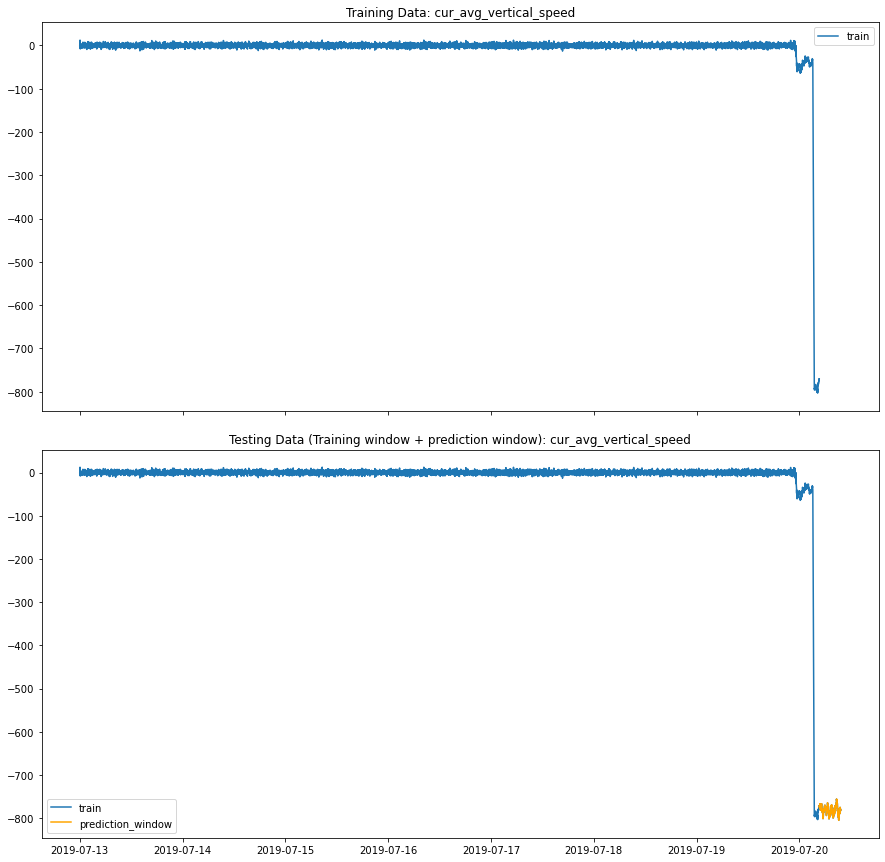

In [96]:
# Create a plot of the testing and training data for a given feature 
fig, axs = plt.subplots(2, sharex=True, figsize=(15,15))
axs[0].plot(train_data, label='train')
axs[0].set_title(f"Training Data: {feature}")
axs[0].legend()
axs[1].plot(test_data, label='train')
axs[1].plot(test_data.tail(prediction_length), 'orange', label='prediction_window')
axs[1].set_title(f"Testing Data (Training window + prediction window): {feature}")
axs[1].legend()
plt.subplots_adjust(hspace=0.1, wspace=0.1)


### Writing data to S3 buckets

In [98]:
# Writing training results to s3 bucket 
write_to_s3_json(file_name_train, bucket, train_input)

# Writing testing results to s3 bucket 
write_to_s3_json(file_name_test, bucket, test_input)


### Training DeepAR Algorithm 

In [99]:
# Importing DeepAR Algorithm Image 
from sagemaker.amazon.amazon_estimator import get_image_uri
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", boto3.Session().region_name)

In [100]:
# Setting estimator and hyperparameters objects 
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_uri,
    role=execution_role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    base_job_name="Deepar-job",
    output_path=f"s3://{data_output}"
)

hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10",
}

estimator.set_hyperparameters(**hyperparameters)

In [101]:
# Building data channels for DeepAR (where test and training sets are located)
train_location = f"s3://{bucket}/{train_input}" # Where training data is located 
test_location = f"s3://{bucket}/{test_input}" # Where to store output 

# Currently using only train_lication as there is an error with test_location
data_channels = {"train": train_location}

# Show data channels 
data_channels


{'train': 's3://sagemaker-us-east-1-981537519177/sagemaker/DeepAR/data/train'}

In [102]:
# Training DeepAR Algorithm 
estimator.fit(inputs=data_channels)

2021-08-02 23:42:21 Starting - Starting the training job...
2021-08-02 23:42:45 Starting - Launching requested ML instancesProfilerReport-1627947741: InProgress
......
2021-08-02 23:43:45 Starting - Preparing the instances for training............
2021-08-02 23:45:50 Downloading - Downloading input data
2021-08-02 23:45:50 Training - Downloading the training image...
2021-08-02 23:46:08 Training - Training image download completed. Training in progress.Arguments: train
[08/02/2021 23:46:11 INFO 139881675302272] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_la

[08/02/2021 23:46:50 INFO 139881675302272] Epoch[2] Batch[0] avg_epoch_loss=2.871782
[08/02/2021 23:46:50 INFO 139881675302272] #quality_metric: host=algo-1, epoch=2, batch=0 train loss <loss>=2.871781587600708
[08/02/2021 23:46:53 INFO 139881675302272] Epoch[2] Batch[5] avg_epoch_loss=4.093982
[08/02/2021 23:46:53 INFO 139881675302272] #quality_metric: host=algo-1, epoch=2, batch=5 train loss <loss>=4.093982021013896
[08/02/2021 23:46:53 INFO 139881675302272] Epoch[2] Batch [5]#011Speed: 45.82 samples/sec#011loss=4.093982
[08/02/2021 23:46:57 INFO 139881675302272] Epoch[2] Batch[10] avg_epoch_loss=3.909585
[08/02/2021 23:46:57 INFO 139881675302272] #quality_metric: host=algo-1, epoch=2, batch=10 train loss <loss>=3.6883084297180178
[08/02/2021 23:46:57 INFO 139881675302272] Epoch[2] Batch [10]#011Speed: 43.33 samples/sec#011loss=3.688308
[08/02/2021 23:46:57 INFO 139881675302272] processed a total of 321 examples
#metrics {"StartTime": 1627948008.9693842, "EndTime": 1627948017.426667,

[08/02/2021 23:47:35 INFO 139881675302272] Epoch[7] Batch[5] avg_epoch_loss=3.073667
[08/02/2021 23:47:35 INFO 139881675302272] #quality_metric: host=algo-1, epoch=7, batch=5 train loss <loss>=3.073666572570801
[08/02/2021 23:47:35 INFO 139881675302272] Epoch[7] Batch [5]#011Speed: 45.69 samples/sec#011loss=3.073667
[08/02/2021 23:47:37 INFO 139881675302272] processed a total of 312 examples
#metrics {"StartTime": 1627948050.2635338, "EndTime": 1627948057.8819864, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 7617.918491363525, "count": 1, "min": 7617.918491363525, "max": 7617.918491363525}}}

[08/02/2021 23:47:37 INFO 139881675302272] #throughput_metric: host=algo-1, train throughput=40.95534796431282 records/second
[08/02/2021 23:47:37 INFO 139881675302272] #progress_metric: host=algo-1, completed 40.0 % of epochs
[08/02/2021 23:47:37 INFO 139881675302272] #quality_metric: host=algo-1, epoch=7, train loss <los

[08/02/2021 23:48:22 INFO 139881675302272] Epoch[13] Batch[5] avg_epoch_loss=2.853338
[08/02/2021 23:48:22 INFO 139881675302272] #quality_metric: host=algo-1, epoch=13, batch=5 train loss <loss>=2.8533380031585693
[08/02/2021 23:48:22 INFO 139881675302272] Epoch[13] Batch [5]#011Speed: 43.93 samples/sec#011loss=2.853338
[08/02/2021 23:48:25 INFO 139881675302272] processed a total of 312 examples
#metrics {"StartTime": 1627948097.8714554, "EndTime": 1627948105.5919607, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 7720.430135726929, "count": 1, "min": 7720.430135726929, "max": 7720.430135726929}}}

[08/02/2021 23:48:25 INFO 139881675302272] #throughput_metric: host=algo-1, train throughput=40.41150359481934 records/second
[08/02/2021 23:48:25 INFO 139881675302272] #progress_metric: host=algo-1, completed 70.0 % of epochs
[08/02/2021 23:48:25 INFO 139881675302272] #quality_metric: host=algo-1, epoch=13, train loss

[08/02/2021 23:48:59 INFO 139881675302272] Epoch[18] Batch[0] avg_epoch_loss=3.880556
[08/02/2021 23:48:59 INFO 139881675302272] #quality_metric: host=algo-1, epoch=18, batch=0 train loss <loss>=3.8805556297302246
[08/02/2021 23:49:04 INFO 139881675302272] Epoch[18] Batch[5] avg_epoch_loss=3.251032
[08/02/2021 23:49:04 INFO 139881675302272] #quality_metric: host=algo-1, epoch=18, batch=5 train loss <loss>=3.25103223323822
[08/02/2021 23:49:04 INFO 139881675302272] Epoch[18] Batch [5]#011Speed: 38.99 samples/sec#011loss=3.251032
[08/02/2021 23:49:07 INFO 139881675302272] processed a total of 314 examples
#metrics {"StartTime": 1627948138.625294, "EndTime": 1627948147.1456053, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 8519.84429359436, "count": 1, "min": 8519.84429359436, "max": 8519.84429359436}}}

[08/02/2021 23:49:07 INFO 139881675302272] #throughput_metric: host=algo-1, train throughput=36.85464684502762 r

### Deploying Endpoint

In [104]:
# Deploying endpoint 
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name = job_name,
    initial_instance_count = 1,
    instance_type ='ml.m4.xlarge',
    image_uri = image_uri,
    role = execution_role
)

-------------------!

### Building prediction object 
Building the prediction element to pass to the endpoint for DeepAR to forecast results 

In [119]:
# Opening up test data into a data element 
f = open ('test_data.json', "r")
test_data_json = json.loads(f.read())

In [120]:
from sagemaker.predictor import JSONSerializer

predictor = sagemaker.predictor.Predictor(
    endpoint_name, 
    sagemaker_session=sagemaker_session,
    serializer=JSONSerializer())
    
quantiles=str(["0.1", "0.5", "0.9"]),
q1 = '0.1'         # compute p10 quantile
q2 = '0.5'
q3 = '0.9'
num_samples = 100
output_type = ["quantiles"]

configuration = {
    "output_types": output_type,
    "num_samples": num_samples,
    "quantiles": [q1, q2, q3]
}

test_data_model=[]
test_data_model.append(test_data_json)

http_data = {
        "instances": test_data_model, 
        "configuration": configuration
    }
http_data

{'instances': [{'start': '2019-07-13 00:00:00',
   'target': [0.0,
    2.334005,
    6.308643332999999,
    1.8984599999999998,
    12.335346000000001,
    -5.247668333,
    5.703914286,
    4.977575,
    -8.091251111,
    -2.555108,
    3.2848963639999997,
    0.24759916699999998,
    -0.213715385,
    -1.488684286,
    1.4059606669999998,
    0.029174375,
    1.697033529,
    -6.003133332999999,
    1.830635789,
    1.888938,
    -1.5011075,
    -0.2639285,
    0.20745100000000002,
    -1.5596105,
    2.5020175,
    -2.8492535,
    -3.7001505,
    -6.669616499999999,
    0.919743,
    -0.2802725,
    1.4185405,
    2.7527865,
    3.630018,
    -1.518329,
    -4.0156055,
    -0.060360500000000004,
    -3.729598,
    2.8968495,
    -1.410491,
    -0.1513445,
    -3.1320235,
    -2.0936515,
    -2.0744485,
    1.5688815,
    -5.891065,
    7.593235000000001,
    -1.2573239999999999,
    6.0015965,
    4.1731455,
    3.3406540000000002,
    -1.0054584999999998,
    -4.731555999999999,
  

### Obtaining predictions from DeepAR

In [121]:
# Passing data into algorihtm to return predictions 
predictions = predictor.predict(http_data)
print(predictions)

ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint Deepar-job-2021-08-02-23-42-21-271 of account 981537519177 not found.

### Building dataframe of predicted results 
Build timestamps starting from the last timestamp of the test data and the quantile prediction values 

In [108]:
# Last timestamp of the test data
test_data[:-prediction_length].tail()

2019-07-20 04:35:00   -774.207255
2019-07-20 04:36:00   -773.879376
2019-07-20 04:37:00   -771.151727
2019-07-20 04:38:00   -772.621980
2019-07-20 04:39:00   -770.769317
Freq: T, dtype: float64

In [115]:
# Extracting the quantile predictions 
j = json.loads(predictions.decode('utf-8'))

for data in j['predictions']:
    j_data = data['quantiles']

# We are using the complete dataset to compare against the predicted results for DeepAR 
actual_data = test_data

# Building a dataframe with timestamps 
prediction_times = pd.date_range(start=actual_data.index[len(actual_data[:-prediction_length])
], freq=freq, periods=prediction_length)

prediction_results = pd.DataFrame(data=j_data, columns=['0.1', '0.5', '0.9'], index=prediction_times)
prediction_results.head(n=20)


,0.1,0.5,0.9
2019-07-20 04:40:00,-1609.143799,142.571686,1755.290283
2019-07-20 04:41:00,-1125.214478,319.595337,1499.837036
2019-07-20 04:42:00,-1567.934448,-67.754761,1769.709473
2019-07-20 04:43:00,-1842.564697,-22.145081,1842.674561
2019-07-20 04:44:00,-1244.810303,107.401886,1918.298584
2019-07-20 04:45:00,-1040.551758,273.856140,1985.656250
2019-07-20 04:46:00,-1105.203247,423.501434,1869.694458
2019-07-20 04:47:00,-1326.561890,190.060944,1628.709839
2019-07-20 04:48:00,-1280.706177,313.807831,1881.041748
2019-07-20 04:49:00,-1331.035645,307.820862,2034.875366


### Visualization - Plotting predictions against actuals 

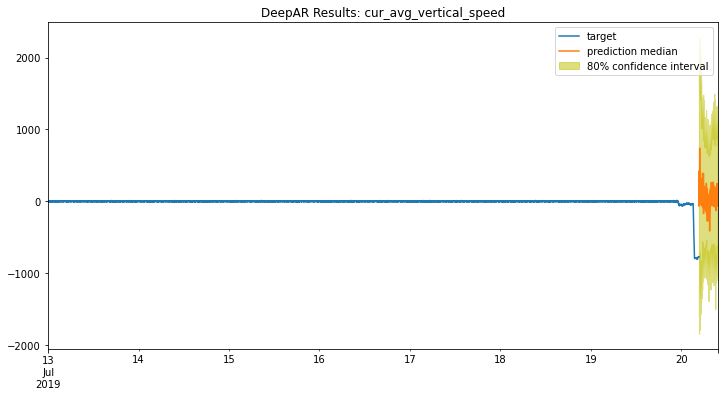

In [116]:
# Plotting predicted values against the actual values
plt.figure(figsize=(12, 6))
test_data.iloc[:-prediction_length].plot(label='target')
p10 = prediction_results["0.1"]
p90 = prediction_results["0.9"]
plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
prediction_results["0.5"].plot(label="prediction median")
plt.title(f"DeepAR Results: {feature}")
plt.legend()
plt.show()

### Visualization - Plotting only predictions 

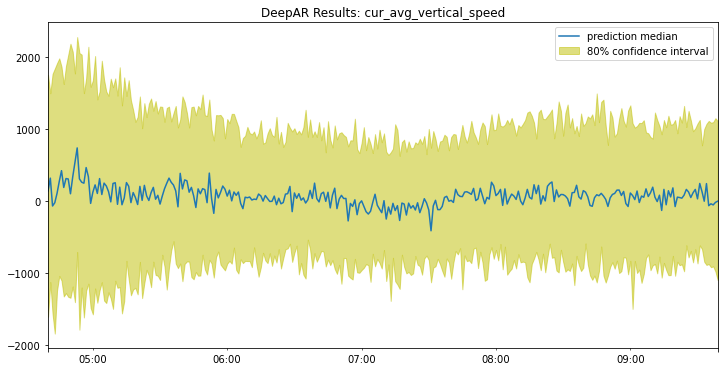

In [117]:
# Plotting only the predicted values 
plt.figure(figsize=(12, 6))
p10 = prediction_results["0.1"]
p90 = prediction_results["0.9"]
prediction_results["0.5"].plot(label="prediction median")
plt.title(f"DeepAR Results: {feature}")
plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
plt.legend()
plt.show()
    

In [122]:
# Deleting endpoint when no longer used 
sagemaker_session.delete_endpoint(endpoint_name)

ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-1:981537519177:endpoint/deepar-job-2021-08-02-23-42-21-271".